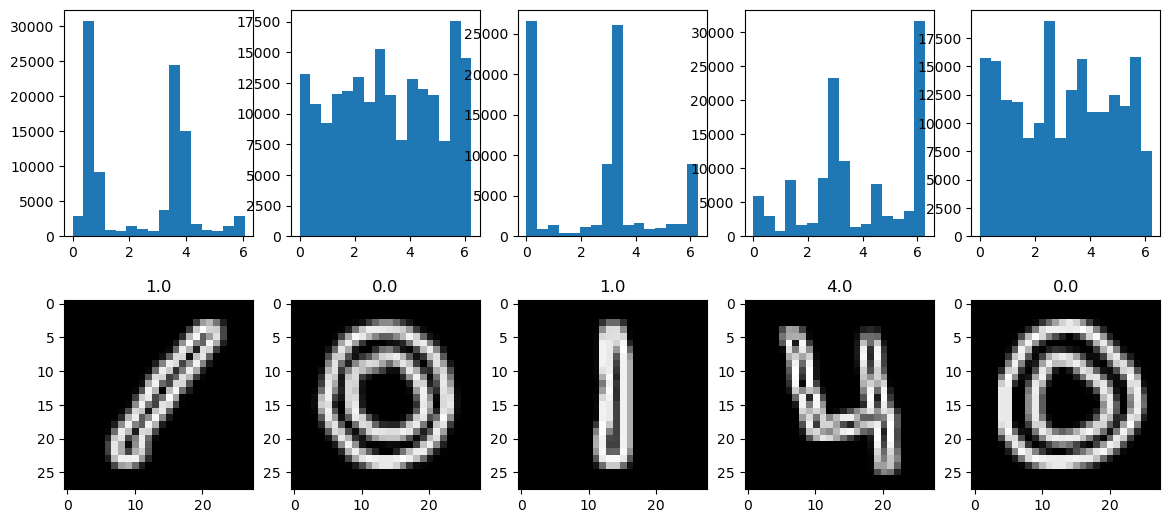

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

train = np.loadtxt('./in/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./in/test.csv', delimiter=',', skiprows=1)

# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)
    

train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)


test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())
    
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
    
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Создадим модель ансамблирования, обучим её и предскажем результаты

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC


stack_model = StackingClassifier(
    [
        ('LinearSVC', LinearSVC()),
        ('DecisionTreeClassifier', DecisionTreeClassifier()),
        ('RandomForestClassifier', RandomForestClassifier())
    ])
stack_model.fit(train_hist, train_label)
predictions_stack = stack_model.predict(test_hist)

C:\Users\vladislav\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Запишем результаты в файл и проверим точность на Kaggle

In [3]:
import pandas as pd

result = pd.DataFrame({'ImageId':list(range(1, predictions_stack.size+1)), 'Label':predictions_stack.astype(int)})
result.to_csv("./out/submission.csv", index=False)

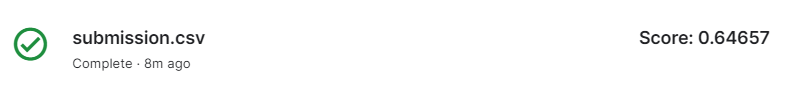